In [50]:
# Libraries

# Torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchsummary
import torch
from torch.utils.data import DataLoader

# General
import numpy as np
import random, os
from tqdm import tqdm
from collections import Counter

# Training
from torchmetrics import Accuracy, Precision, F1Score, Recall
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights

# Data loading
from torchvision.datasets import ImageFolder
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Plots
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In the following code block, we'll define a custom data loader class along with the augmentations.

The load_image_transform() method is used to load the image from disk and make sure it's in RGB channels. The grayscale single-channel is copied to all the 3 channels to allow easier comparision with pretrained models architectures.

This data loader will be used within the training class, and it employs the __getitem__ method to iterate over each sample. When processing samples from the training dataset, it will apply the augmentations specified in self.transform. Additionally, if the image_net parameter is set to true, the input data will be normalized to match the distribution of inputs used for training the pretrained models (image net), specifically:

A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

Let's proceed with the creation of the dataloader class:

In [27]:
# Data Loading and augmentations


class ChestXrayDatasetInMemory(ImageFolder):
    def __init__(self, root_dir, aug=None, num_workers=32):
        super().__init__(root=root_dir)
        self.samples = self.samples
        self.set_aug(aug)
        self.num_workers = num_workers
        self.images = []
        self.labels = []
        self.aug = aug
        
        
        self.load_dataset_into_memory()

    def set_aug(self, aug=False, image_net=True):
        if aug:
            self.transform = A.Compose([
                # A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8)),
                A.Rotate(limit=20, p=0.5),
                A.HorizontalFlip(p=0.5),
                A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=1),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=0.5),
                A.Perspective(scale=(0.05, 0.15), keep_size=True, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.Resize(height=224, width=224),
                (A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) if image_net else A.Normalize(mean=0, std=1)),
                # A.Normalize(mean=0, std=1),
                ToTensorV2()
            ]) 

        else:
            self.transform = A.Compose([
                A.Resize(224, 224),  # Resize images to 200x200
                # ToTensorV2(),          # Convert images to PyTorch tensors
                (A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) if image_net else A.Normalize(mean=0, std=1)),
                # A.Normalize(mean=0, std=1),
                ToTensorV2()
            ])

    def load_image_transform(self, img_label_tuple):
        img_path, label = img_label_tuple
        # image = Image.open(img_path).convert('L')
        image = Image.open(img_path).convert('RGB') # We convert to rgb to allow easier comparision between models
        image = np.array(image)
        return image, label

    def load_dataset_into_memory(self):
        # Using ThreadPoolExecutor to parallelize image loading
        with ThreadPoolExecutor(max_workers=self.num_workers) as executor:  
            # Prepare running tasks
            futures = [executor.submit(self.load_image_transform, img_label) for img_label in self.samples]
            results = []
            
            # Process as tasks complete
            for future in tqdm(as_completed(futures), total=len(futures), desc="Loading dataset into memory"):
                image, label = future.result()
                self.images.append(image)
                self.labels.append(label)
        
        # Shuffle samples
        indices = list(range(len(self.images)))
        random.shuffle(indices)

        # Use the shuffled indices to reorder both lists
        self.images = [self.images[i] for i in indices]
        self.labels = [self.labels[i] for i in indices]


    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        image = self.transform(image=image)['image']
        return image, label

We will now define the Training class, which automates the process of training and evaluating the model.

In the initialization, the class requires the specification of train_loader, test_loader, and the model itself. It also allows for the customization of various parameters, including the learning rate, weight decay, and the weights to balance the loss function.

The chosen loss function is the cross-entropy function. For optimization, the Adam optimizer is used.

Several performance metrics are tracked, such as Accuracy, Precision, Recall, and F1 Score.

The train method takes a single argument, num_epochs, which specifies the epoch count. It iterates over batches from self.train_loader, processes each batch within a loop, transfers them to the GPU with .to(self.device), calculates the loss, and updates the optimizer. Performance metrics are computed during this process, and progress is visually tracked using a tqdm progress bar.

In the test() method, the model is switched to evaluation mode, ensuring that weights remain unchanged during testing. This method is similar to the training process but operates on test_loader.


In [22]:
# Training class

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Trainer:
    def __init__(self, train_loader, test_loader, model, lr=1e-5, weight_decay=1e-9, weights=[3876/(1342+3876), 1342/(1342+3876)]):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.weights = torch.FloatTensor(weights).to(self.device)
        # Initialize the model
        self.model = model.to(self.device)
        self.lr = lr
        # Loss and optimizer
        self.criterion = nn.CrossEntropyLoss(weight=self.weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)#, weight_decay=weight_decay)
        # self.optimizer = optim.RMSprop(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        # self.optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        # Metrics
        self.accuracy_metric = Accuracy(task='multiclass', num_classes=2,average='macro').to(self.device)
        self.precision_metric = Precision(task='multiclass', num_classes=2, average='macro').to(self.device)
        self.recall_metric = Recall(task='multiclass', num_classes=2, average='macro').to(self.device)
        self.f1_metric = F1Score(task='multiclass', num_classes=2, average='macro').to(self.device)


    def train(self, num_epochs=10):
        accs = []
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'max', patience=2)

        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            
            # Reset metrics at the start of each epoch
            self.accuracy_metric.reset()
            self.precision_metric.reset()
            self.f1_metric.reset()
            self.recall_metric.reset()
            
            with tqdm(self.train_loader, unit="batch") as tepoch:
                for images, labels in tepoch:
                    tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
                    
                    images, labels = images.to(self.device), labels.to(self.device)
                    
                    # Forward pass
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                    
                    # Backward and optimize
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    
                    # Update metrics
                    self.accuracy_metric.update(outputs, labels)
                    self.precision_metric.update(outputs, labels)
                    self.f1_metric.update(outputs, labels)
                    self.recall_metric.update(outputs, labels)
                    
                    running_loss += loss.item()
                    tepoch.set_postfix(loss=running_loss/len(self.train_loader))
            
            # Compute metrics at the end of each epoch
            accuracy = self.accuracy_metric.compute()
            precision = self.precision_metric.compute()
            f1 = self.f1_metric.compute()
            recall = self.recall_metric.compute()

            accs.append(accuracy.item())
            
            # Print metrics at the end of each epoch
            print(f'Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(self.train_loader)}, '
                f'Accuracy: {accuracy}, Precision: {precision}, F1 Score: {f1}, Recall: {recall}')

            res = self.test()
            self.scheduler.step(res['test_accuracy'])

        return {
            'train_accuracy': accuracy.item(),
            'train_precision': precision.item(),
            'train_recall': recall.item(),
            'train_f1': f1.item(),
            'train_acc_avg':np.array(accs).mean(),
            'train_acc_std':np.array(accs).std(),
            'train_sharpe':np.array(accs).mean()/np.array(accs).std(),
        }

    def test(self):
        self.model.eval()

        self.accuracy_metric.reset()
        self.precision_metric.reset()
        self.f1_metric.reset()
        self.recall_metric.reset()

        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                
                # Update metrics
                self.accuracy_metric.update(outputs, labels)
                self.precision_metric.update(outputs, labels)
                self.f1_metric.update(outputs, labels)
                self.recall_metric.update(outputs, labels)

            # Compute metrics
            accuracy = self.accuracy_metric.compute()
            precision = self.precision_metric.compute()
            f1 = self.f1_metric.compute()
            recall = self.recall_metric.compute()


            print(f'Test - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, F1 Score: {f1:.2f}, Recall: {recall:.2f}')

        return {
            'test_accuracy': accuracy.item(),
            'test_precision': precision.item(),
            'test_recall': recall.item(),
            'test_f1': f1.item()
        }


In the following section we will build the ResNet50 architecture (the best performing model amongst all the tested one).

For the ResNet50 we will use the pretrained weights and change the last layer to output 2 classes instead of the 1k for imagenet.

In [49]:
# ResNet50
model_resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_resnet50.fc.in_features  # Get the number of features in input to the final fully connected layer
model_resnet50.fc = nn.Linear(num_ftrs, 2)  # Adjust the layer to have 2 output features
model_resnet50.to(device)

torchsummary.summary(model_resnet50, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

From the image below we can see that even if the ResNet50 network has more layers it is more lightweight compared to AlexNet and VGG16. 

The total trainable parameters are:
- ResNet50 -> 24M
- AlexNet -> 57M
- VGG16 -> 138M


Now, we will load the dataset into memory and set up two loaders: train_loader for the training phase and test_loader for testing. __We will not be loading the validation set__, as it consists of only one patient with eight samples, which we believe insufficient for effectively monitoring training overfitting.

In [29]:
# Training
dataset_path  = 'data/chest_xray/' 


train_dataset = ChestXrayDatasetInMemory(os.path.join(dataset_path, 'train'), aug=True)
test_dataset = ChestXrayDatasetInMemory(os.path.join(dataset_path, 'test'), aug=False)


Loading dataset into memory: 100%|██████████| 624/624 [00:03<00:00, 188.59it/s]


Let's now have a look at the train and test dataset distribution of the two labels: PNEUOMONIA and NORMAL.

In [56]:
def plot_class_distribution(dataset, dataset_name):
    # Count the frequency of each class
    label_counts = Counter(dataset.labels)
    labels = list(label_counts.keys())
    frequencies = list(label_counts.values())
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(labels, frequencies, color=['blue', 'orange'])
    plt.title(f'Class Distribution in {dataset_name} Dataset')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(labels, ['PNEUNOMIA', 'NORMAL'])
    plt.show()

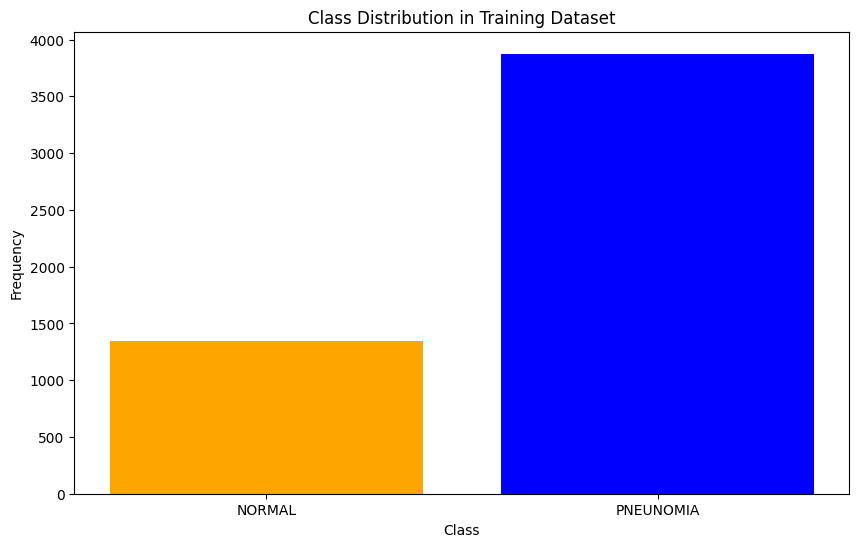

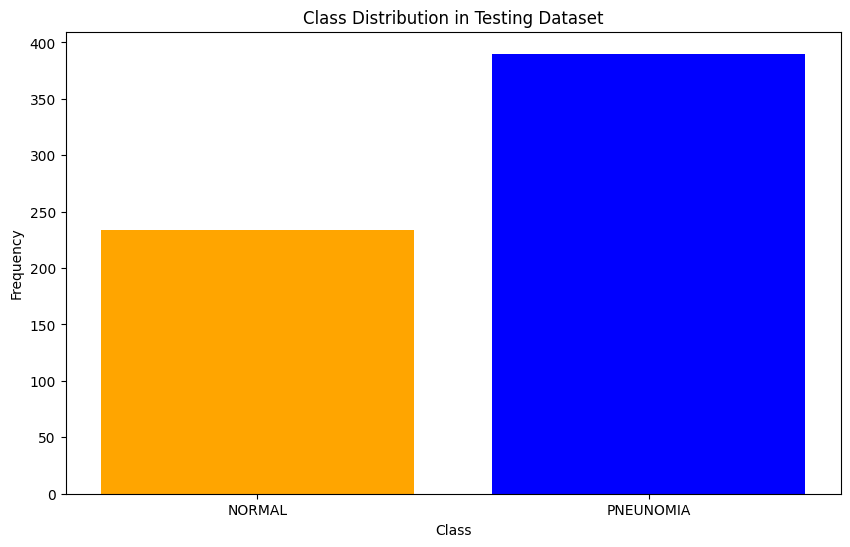

In [57]:
plot_class_distribution(train_dataset, 'Training')
plot_class_distribution(test_dataset, 'Testing')

We can see that the dataset is clearly imbalance and this could lead to a biased result, where the model is better at predicting PNEUNOMIA rather than NORMAL classes. It is relvant to note that this is usuallhy preferred in the medical domain, to have less false negatives but can still have bad effects in the model. 

In the test we have performned we have seen that adding a weighting mechanism improves the model accuracy.

We will now start the training and show the result of the best performing model with the best performing parameters. 

Conducting a proper comparison of all models here is time-consuming and not the best approach. Therefore, we will focus on showing the top-performing model, ResNet50 (pretrained). For a detailed comparison, please refer to the table provided in the PDF uploaded on Canvas.

In [43]:
batch_size = 64
train_dataset.set_aug(aug=True, image_net=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

trainer = Trainer(train_loader, test_loader, model=model_resnet50)

train_metrics = trainer.train(num_epochs=18)  # Ensure your train method returns the validation metric of interest
test_metrics = trainer.test()  # Ensure your train method returns the validation metric of interest

  0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 1/18: 100%|██████████| 82/82 [01:57<00:00,  1.43s/batch, loss=0.587] 


Epoch 1/18 - Loss: 0.5871078103053861, Accuracy: 0.7903436422348022, Precision: 0.7313363552093506, F1 Score: 0.740298867225647, Recall: 0.7903436422348022
Test - Accuracy: 0.83, Precision: 0.84, F1 Score: 0.83, Recall: 0.83


Epoch 2/18: 100%|██████████| 82/82 [01:56<00:00,  1.43s/batch, loss=0.329] 


Epoch 2/18 - Loss: 0.32853500835779237, Accuracy: 0.9135716557502747, Precision: 0.8501579761505127, F1 Score: 0.8713784217834473, Recall: 0.9135716557502747
Test - Accuracy: 0.84, Precision: 0.84, F1 Score: 0.84, Recall: 0.84


Epoch 3/18: 100%|██████████| 82/82 [01:57<00:00,  1.44s/batch, loss=0.218] 


Epoch 3/18 - Loss: 0.2183589862614143, Accuracy: 0.9324531555175781, Precision: 0.8838109970092773, F1 Score: 0.9031507968902588, Recall: 0.9324531555175781
Test - Accuracy: 0.86, Precision: 0.89, F1 Score: 0.87, Recall: 0.86


Epoch 4/18: 100%|██████████| 82/82 [01:58<00:00,  1.44s/batch, loss=0.173] 


Epoch 4/18 - Loss: 0.17254834049722043, Accuracy: 0.9480811357498169, Precision: 0.910529375076294, F1 Score: 0.926709771156311, Recall: 0.9480811357498169
Test - Accuracy: 0.89, Precision: 0.91, F1 Score: 0.90, Recall: 0.89


Epoch 5/18: 100%|██████████| 82/82 [01:57<00:00,  1.44s/batch, loss=0.149] 


Epoch 5/18 - Loss: 0.14875259077767047, Accuracy: 0.9508762359619141, Precision: 0.9203304648399353, F1 Score: 0.9339717030525208, Recall: 0.9508762359619141
Test - Accuracy: 0.90, Precision: 0.93, F1 Score: 0.91, Recall: 0.90


Epoch 6/18: 100%|██████████| 82/82 [01:57<00:00,  1.43s/batch, loss=0.132] 


Epoch 6/18 - Loss: 0.13196368102075123, Accuracy: 0.9564682245254517, Precision: 0.9289853572845459, F1 Score: 0.9414523243904114, Recall: 0.9564682245254517
Test - Accuracy: 0.91, Precision: 0.94, F1 Score: 0.92, Recall: 0.91


Epoch 7/18: 100%|██████████| 82/82 [01:57<00:00,  1.43s/batch, loss=0.128]  


Epoch 7/18 - Loss: 0.12809269929804454, Accuracy: 0.9550907611846924, Precision: 0.9341697692871094, F1 Score: 0.9439136981964111, Recall: 0.9550907611846924
Test - Accuracy: 0.91, Precision: 0.94, F1 Score: 0.92, Recall: 0.91


Epoch 8/18: 100%|██████████| 82/82 [01:56<00:00,  1.42s/batch, loss=0.122] 


Epoch 8/18 - Loss: 0.12203672846279494, Accuracy: 0.9573856592178345, Precision: 0.9317950010299683, F1 Score: 0.9434998035430908, Recall: 0.9573856592178345
Test - Accuracy: 0.92, Precision: 0.95, F1 Score: 0.93, Recall: 0.92


Epoch 9/18: 100%|██████████| 82/82 [01:58<00:00,  1.45s/batch, loss=0.108] 


Epoch 9/18 - Loss: 0.10751175587406246, Accuracy: 0.9632072448730469, Precision: 0.9398549795150757, F1 Score: 0.950650155544281, Recall: 0.9632072448730469
Test - Accuracy: 0.93, Precision: 0.95, F1 Score: 0.94, Recall: 0.93


Epoch 10/18: 100%|██████████| 82/82 [01:56<00:00,  1.43s/batch, loss=0.0986]


Epoch 10/18 - Loss: 0.09864932739334863, Accuracy: 0.9671075344085693, Precision: 0.9441208839416504, F1 Score: 0.9547725915908813, Recall: 0.9671075344085693
Test - Accuracy: 0.90, Precision: 0.94, F1 Score: 0.92, Recall: 0.90


Epoch 11/18: 100%|██████████| 82/82 [01:56<00:00,  1.42s/batch, loss=0.0855] 


Epoch 11/18 - Loss: 0.08546532406585246, Accuracy: 0.9705771803855896, Precision: 0.9518598914146423, F1 Score: 0.960677981376648, Recall: 0.9705771803855896
Test - Accuracy: 0.91, Precision: 0.94, F1 Score: 0.92, Recall: 0.91


Epoch 12/18: 100%|██████████| 82/82 [01:56<00:00,  1.42s/batch, loss=0.0885] 


Epoch 12/18 - Loss: 0.08852151779049053, Accuracy: 0.9670923948287964, Precision: 0.9500880241394043, F1 Score: 0.9581430554389954, Recall: 0.9670923948287964
Test - Accuracy: 0.92, Precision: 0.95, F1 Score: 0.93, Recall: 0.92


Epoch 13/18: 100%|██████████| 82/82 [01:57<00:00,  1.44s/batch, loss=0.0887] 


Epoch 13/18 - Loss: 0.08869717756240833, Accuracy: 0.9678674936294556, Precision: 0.9452203512191772, F1 Score: 0.9557303190231323, Recall: 0.9678674936294556
Test - Accuracy: 0.92, Precision: 0.95, F1 Score: 0.93, Recall: 0.92


Epoch 14/18: 100%|██████████| 82/82 [01:56<00:00,  1.43s/batch, loss=0.0813] 


Epoch 14/18 - Loss: 0.0813422983103409, Accuracy: 0.9720258712768555, Precision: 0.9501340985298157, F1 Score: 0.9603322744369507, Recall: 0.9720258712768555
Test - Accuracy: 0.91, Precision: 0.95, F1 Score: 0.93, Recall: 0.91


Epoch 15/18: 100%|██████████| 82/82 [01:56<00:00,  1.42s/batch, loss=0.0881] 


Epoch 15/18 - Loss: 0.08808592684203531, Accuracy: 0.9706777334213257, Precision: 0.950586199760437, F1 Score: 0.9600051641464233, Recall: 0.9706777334213257
Test - Accuracy: 0.91, Precision: 0.94, F1 Score: 0.92, Recall: 0.91


Epoch 16/18: 100%|██████████| 82/82 [01:57<00:00,  1.44s/batch, loss=0.0811]


Epoch 16/18 - Loss: 0.08114789471757121, Accuracy: 0.9734594821929932, Precision: 0.9544296264648438, F1 Score: 0.9633898138999939, Recall: 0.9734594821929932
Test - Accuracy: 0.91, Precision: 0.94, F1 Score: 0.92, Recall: 0.91


Epoch 17/18: 100%|██████████| 82/82 [01:56<00:00,  1.42s/batch, loss=0.0839] 


Epoch 17/18 - Loss: 0.08393475005584883, Accuracy: 0.970734715461731, Precision: 0.9537975788116455, F1 Score: 0.9618275165557861, Recall: 0.970734715461731
Test - Accuracy: 0.92, Precision: 0.95, F1 Score: 0.93, Recall: 0.92


Epoch 18/18: 100%|██████████| 82/82 [01:56<00:00,  1.42s/batch, loss=0.0917]


Epoch 18/18 - Loss: 0.09173972170981692, Accuracy: 0.9681540727615356, Precision: 0.9473987817764282, F1 Score: 0.9571000933647156, Recall: 0.9681540727615356
Test - Accuracy: 0.92, Precision: 0.95, F1 Score: 0.93, Recall: 0.92
Test - Accuracy: 0.92, Precision: 0.95, F1 Score: 0.93, Recall: 0.92


We can see that the model reaches a __testing accuracy of 0.92 and train accuracy of 0.96.__

We will now show the correct and wrong predictions for each class using a confusion matrix: 

In [46]:
def plot_confusion_matrix(model, device, test_loader, class_names):
    model.eval()  # set the model to evaluation mode
    y_pred = []
    y_true = []

    with torch.no_grad():  # no need to track the gradients
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())  # add predicted to y_pred
            y_true.extend(labels.cpu().numpy())  # add true labels to y_true

    cm = confusion_matrix(y_true, y_pred)

    # plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    return cm 


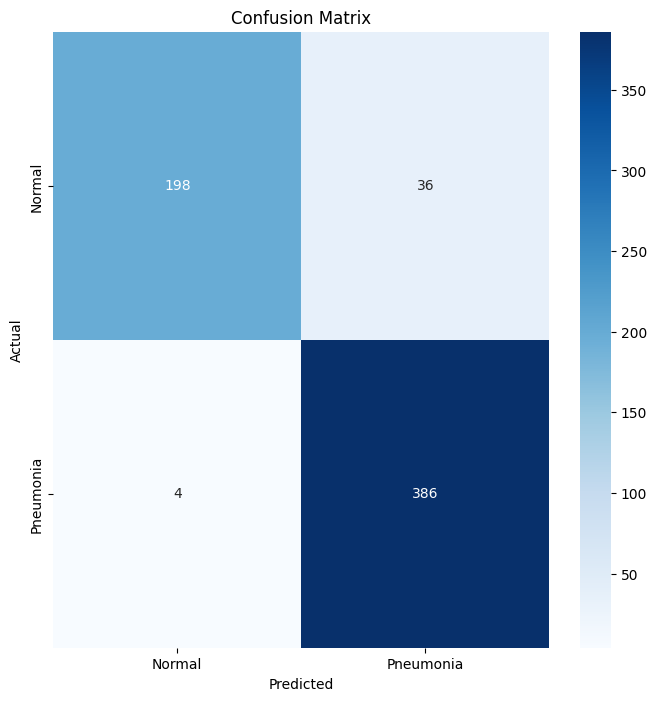

In [47]:
class_names = ['Normal', 'Pneumonia']
cm = plot_confusion_matrix(model_resnet50, device, test_loader, class_names)

The model shows promising balanced results between the PNEUOMONIA and NORMAL classes, despite their significance imbalance. This is likely to be attributed to the weighting mechanism incorporated within the loss function.
 